# Automated Pollen grain Classification in Fossil Pollen using Deep Learning

In this document we share our process of extracting, purifying and augmenting our raw data into the published Dataset, as well as training and evaluating our Deep Learning approach.

### 0. Environment Setup

This jupyter-notebook document is used to replicate the work in our study (doi:), if you only want to test the model or show how it can be applied on other images use the file: test.ipynb that is located in the same directory as this document.

Before running the cells below, make sure that you have downloaded all required libraries (e.g., image dataset for training the object detection or classification model).

This project was created with the python version 3.8.10 and may be updated in the future for compatibility reasons. Additionally, please not that this project was done with Windows version 11 and the following code is supposed to work for computers that use Windows version 8 or above and successfully have installed a python version (https://www.python.org/downloads/) on the computer. Mac Os or Linux users may need to install the packages manually. Compatibility for other systems may be added in the future.

I suggest using VisualStudioCode (https://code.visualstudio.com/download) which was also used in this project. 

In [1]:
# This downloads and installs pip which is a python package that makes further installation of packages easier. Make sure pip is successfull installed
!python -m ensurepip --upgrade

Looking in links: c:\Users\robin\AppData\Local\Temp\tmps2z4f1iv


In [2]:
# If this command does return an Error statement, pip has not been successfully installed, make sure to manually install pip using the Link beneath, before following the rest of the notebook.
%pip list

Package           VersionNote: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\robin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.



----------------- --------
asttokens         2.0.5
backcall          0.2.0
colorama          0.4.4
debugpy           1.6.0
decorator         5.1.1
dict2xml          1.7.2
distlib           0.3.4
entrypoints       0.4
executing         0.8.3
filelock          3.6.0
imutils           0.5.4
ipykernel         6.13.0
ipython           8.3.0
jedi              0.18.1
jupyter-client    7.3.0
jupyter-core      4.10.0
matplotlib-inline 0.1.3
nest-asyncio      1.5.5
numpy             1.22.2
opencv-python     4.5.5.62
packaging         21.3
pandas            1.5.1
parso             0.8.3
pickleshare       0.7.5
pip               22.0.4
platformdirs      2.5.1
prompt-toolkit    3.0.29
psutil            5.9.0
pure-eval         0.2.2
pygame            2.4.0
Pygments          2.12.0
pyparsing         3.0.8
python-dateutil   2.8.2
pytz              2022.6
pywin32           304
pyzmq             19.0.2
setuptools        58.1.0
six               1.16.0
stack-data        0.2.0
tornado           6.1
trait

Manual download step by step for pip: https://pip.pypa.io/en/stable/installation/

In [4]:
!pip install virtualenv
# Create and activate a new virtual python environment
!python -m venv pollengrains
!.\pollengrains\Scripts\activate

You should consider upgrading via the 'C:\Users\robin\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


If you are using VSCode as proposed, you have to change the interpreter manually by pressing (Ctrl + Shift + P). Then search for Python: Select Interpreter and browse for the file called python.exe in the main directory of this project in .\pollengrains\Scripts\python.exe 

In [3]:
# Download the necessary packages (with the samse versions) used in this project
!pip install -r requirements.txt

  Using cached aicspylibczi-3.0.5-cp310-cp310-win_amd64.whl (560 kB)
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached cachetools-5.0.0-py3-none-any.whl (9.1 kB)
  Using cached Cython-3.0.0a10-py2.py3-none-any.whl (1.1 MB)
  Using cached cztile-0.1.2-py3-none-any.whl (12 kB)
  Using cached dict2xml-1.7.2-py3-none-any.whl
  Using cached dicttoxml-1.7.16-py3-none-any.whl (24 kB)
  Using cached google_api_python_client-2.41.0-py2.py3-none-any.whl (8.3 MB)
  Using cached google_auth-2.6.0-py2.py3-none-any.whl (156 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached googleapis_common_protos-1.55.0-py2.py3-none-any.whl (212 kB)
  Using cached grad-cam-1.4.6.tar.gz (7.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished wit

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\robin\AppData\Local\Temp\pip-install-wt_fl1tb\python-javabridge_e111d97e385a4c35b3bb0c05a93af0a9\setup.py", line 412, in <module>
          ext_modules=ext_modules(),
        File "C:\Users\robin\AppData\Local\Temp\pip-install-wt_fl1tb\python-javabridge_e111d97e385a4c35b3bb0c05a93af0a9\setup.py", line 100, in ext_modules
          from numpy import get_include
      ModuleNotFoundError: No module named 'numpy'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentione

In [1]:
# Imports generic packages
import os
import numpy as np
import cv2
import tensorflow as tf
import xml.etree.ElementTree as ET
import random
import shutil
import matplotlib.pyplot as plt
import tqdm
import tf_explain
import uuid

from tensorflow import keras
from tensorflow.keras.layers import RandomFlip
from tensorflow_addons.image import sharpness, random_hsv_in_yiq, rotate, gaussian_filter2d
from tensorflow.keras.preprocessing.image import random_zoom,random_rotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import image_dehazer


# Imports custom packages
#import EXTRACTION.extractor as extractor
import code_snypets

In [2]:
files = {"SAMPLE_AUGMENTATION" : os.path.join("images","SAMPLE_IMAGES", "sample_cnn_augmentation.jpg"),
         "SAMPLE_SEGMENTATION_IMG" : os.path.join("images", "SAMPLE_IMAGES", "sample_segmentation.jpg"),
         "SAMPLE_SEGMENTATION_XML" : os.path.join("images", "SAMPLE_IMAGES", "sample_segmentation.xml"),
         "SAMPLE_GRAD_CAM" : os.path.join("images", "SAMPLE_IMAGES", "sample_visual.jpg")}

folders = {"LABELIMG_PATH" : os.path.join("tools", "labelimg"),
           
           # Folders for Classification
           "REVIEWED_CNN" : os.path.join("images", "REVIEWED_CNN"),
           "DB_CNN" : os.path.join("images", "DATABASE", "DB_CNN"),
           "CNN_TRAINING_SPLITS" : os.path.join("images", "TRAINING", "CNN"),
           "CNN_MODEL" : os.path.join("model", "CNN_MODEL"),
           "CNN_LOGS" : os.path.join("model", "CNN_MODEL", "logs"),
           "CNN_WEIGHTS" : os.path.join("model", "CNN_MODEL", "weights"),
           "CNN_FINE_TUNE" : os.path.join("model", "CNN_MODEL", "weights", "finetune"),
            
            #Folders for Object Detection
            "REVIEWED_OD" : os.path.join("images", "REVIEWED_OD"),
            "DB_OD" : os.path.join("images", "DATABASE", "DB_OD"),
            "OD_TRAINING_SPLITS" : os.path.join("images",  "TRAINING", "SEGMENTATION"),
            "OD_MODEL"  : os.path.join("images"),

            #Folder for model visualizations grad_cam, activations, etc.
            "VISUALIZATION_PATH" : os.path.join("visuals")
            }



Maybe you forgot to download the whole library, or you are missing individual files/folders. Also make sure, that this jupyter notebook is in the workspace directory, which should be the main library.


In [6]:
#-------------------------------------------------------------------------
# general variables
seed = 0

#-------------------------------------------------------------------------
#variables for CZI-file image extraction
tileDimensions = (1200,1200) # output size of individual tiles
tileShift = 200 # overlap between tiles
imposeFunction = 0 # which focus-stacking algorithm to use. 

#-------------------------------------------------------------------------
#variables for Preprocessing
ANNOTATION_PATH = "" # To be configured. When cropping pollen grains on input images using this Path as parent directory.

#-------------------------------------------------------------------------
#variables for Classification Module
min_pollen_counts = 35 # For rare pollen types e.g. Chenopodiaceae and Helianthemum, additional images will be artificial generated until it reaches min_pollen_counts
fold = 5 # Used to partition the dataset in equal amounts and subsequently using each partition once as validation set and the rest as training set in n-fold repeated training loops.
cnnInputSize = (140,140) # Input Shape for classification module.

learning_rate = 0.00005 # Initial learning rate for CNN-Training loop
batch_size = 32 # How many images will be batched and processed together.
epochs = 150 # 150

#-------------------------------------------------------------------------
#variables for Object Detection Module

In [6]:
# Download and setup dataset


# Download and setup LabelImg

if not os.path.exists(folders["LABELIMG_PATH"]):
    !mkdir {folders["LABELIMG_PATH"]}
    !git clone https://github.com/tzutalin/labelImg {folders["LABELIMG_PATH"]}

if os.name == 'posix':
    !make qt5py3
if os.name =='nt':
    !cd {LABELIMG_PATH} && pyrcc5 -o libs/resources.py resources.qrc


# Check if folder - Setup was correct
for folder in folders.values():
    try:
        assert os.path.exists(folder)
    except AssertionError as e:
        print(e)
        print("Maybe you forgot to download the whole library, or you are missing individual files/folders. Also make sure, that this jupyter notebook is in the workspace directory, which should be the main library.")
        break

### 1. Extracting image tiles from .CZI files 
We used the Python package pczilibrary published by the ZEISS cooperation to extract squared images that could be processed by our semantic segmentation model. The resulted multistack images were projected on one plane using the method described by (). Since the .czi files used in this project were as big as 300 GB we only included a sample .czi file in this Repository to show the methodlogy. For detailed information about the code that is used in this section, move to the declaration in extractor.py.

### 2. Image Annotation

We used the popular LabelImg implementation () to manually annotate pollen that fullfilled the list of criteria that was established by our team. These candidates were then clipped out of the original image and then distributed and double confirmed by the beginner and expert palynologist.

In [ ]:
# Opens LabelImg for manual annotation
!cd {LABELIMG_PATH} && python labelImg.py

In [ ]:
# Show sample image of annotated pollen grains


In [ ]:


try:
    assert os.path.exists(folders["REVIEWED_CNN"])
    try: 
        assert ANNOTATION_PATH != ""
    except:
        print("ANNOTATION_PATH needs to be configured!!")
    extract_cropped_pollen(ANNOTATION_PATH, folders["REVIEWED_CNN"])
except AssertionError:
    print("execute the second command block to create the folder structure")


### 3. Database Split
In this section we discuss how the initial raw database was augmented, enlarged and split into training, validation and test sets for the training of the semnatic segmentation model, as well as for the CNN classifier. For the CNN classifier we used data augmentation methods as proposed by (). For Chenopodiaceae and Helianthemum we first increased the number of images using the same technique as poroposed by (). Since per class counts in our dataset were highly unbalanced, we were striving to use the proposed amount of images 

##### 3.1. Expand Datasets for Chenopodiaceae and Helianthemum
As previosuly done in () we expanded our image dataset for rare classes by augmenting sampled grains with data augmentation techniques. Contrary to mentioned paper, we used random HUE adjustment and random zoom, as we belief these techniques better represent / fill in the blanks in our data variation. 

In [8]:
flipping = keras.Sequential(
        [RandomFlip("horizontal_and_vertical")]
    )

def random_flip(input):
    """The function first flips the image (horizontally or vertically or both) and then rotates it by either 90, 180 or 270 degrees.
    input: np.ndarray - must be some kind of ArrayLike image representation.
    
    => returns:  ArrayLike image"""


    input = cv2.flip(np.asarray(input), random.choice([0,1,-1]))
    input = cv2.rotate(input, random.choice([cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_CLOCKWISE]))
    return input

def expand_data(input, max_delta_hue : float, height_factor : tuple, width_factor : tuple):
    """ Returns an augmented image from the input by applying zoom and hue adjustments on the original input.
    input : np.ndarray      must be some kind of ArrayLike image representation.
    max_delta_hue : float   defines the maximum possible movement from the hue in the yiq color space.
    height_factor : tuple  defines the range in which the image will be zoomed out from in the y-axis.
    width_factor  : tuple defines the range in which the image will be zoomed out from in the x-axis.
        """
    layer = tf.keras.layers.RandomZoom(height_factor = height_factor, width_factor = width_factor, interpolation = "bilinear", fill_mode = "constant", fill_value = 255)
    aug = random_hsv_in_yiq(input, max_delta_hue= max_delta_hue)
    aug = layer(aug)
    return random_flip(aug)


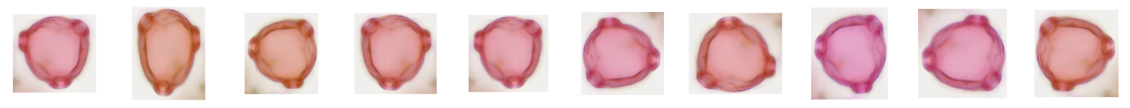

In [8]:
random.seed(seed)

plt.figure(figsize=(20,20))
sample_img = np.asarray(cv2.cvtColor(cv2.imread(SAMPLE_EXPANDING_PATH), cv2.COLOR_BGR2RGB))


for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    augmented_image = expand_data(sample_img, 0.3, height_factor= (0, 0.3), width_factor= (0, 0.3))
    plt.imshow(random_flip(augmented_image))
    plt.axis("off")

In [30]:
# Expanding number of Helianthemum images from 35 up to 210
CHE_POLLEN_PATH = os.path.join(folders["REVIEWED_CNN", "CHENOPODIACEAE"])
CHE_ORIGINALS = os.listdir(CHE_POLLEN_PATH)

random.shuffle(CHE_ORIGINALS)

number = 0
while len(os.listdir(CHE_POLLEN_PATH)) < min_pollen_counts:
    if len(CHE_ORIGINALS) == 0:
        CHE_ORIGINALS = os.listdir(CHE_POLLEN_PATH)
    sample_file = os.path.join(CHE_POLLEN_PATH, CHE_ORIGINALS.pop())
    sample_img = np.array(cv2.imread(sample_file))
    augmented_img = expand_data(sample_img, 0.3, height_factor= (0, 0.1), width_factor= (0, 0.1))
    cv2.imwrite(os.path.join(CHE_POLLEN_PATH, "AUG{}_".format(number) + os.path.basename(sample_file)), augmented_img)
    number += 1




# Expanding number of Helianthemum images from ... up to ...
HE_POLLEN_PATH = os.path.join(folders["REVIEWED_CNN"], "HELIANTHEMUM")
HE_ORIGINALS = os.listdir(HE_POLLEN_PATH)

random.shuffle(HE_ORIGINALS)

number = 0
while len(os.listdir(HE_POLLEN_PATH)) < min_pollen_counts:
    if len(HE_ORIGINALS) == 0:
        HE_ORIGINALS = os.listdir(HE_POLLEN_PATH)
    sample_file = os.path.join(HE_POLLEN_PATH, HE_ORIGINALS.pop())
    sample_img = np.array(cv2.imread(sample_file))
    augmented_img = expand_data(sample_img, 0.3, height_factor= (0, 0.1), width_factor= (0, 0.1))
    cv2.imwrite(os.path.join(HE_POLLEN_PATH, "AUG{}_".format(number) + os.path.basename(sample_file)), augmented_img)
    number += 1

##### 3.2. Build Dataset of original photographs.
To create a balanced dataset, we assessed the amount of images per class for each slide that we used as training dataset. Then we "filtered out" an even amount of images across all slides.


In [14]:
random.seed(seed)

build_database(folders["REVIEWED_CNN"], folders["DB_CNN"])

100%|██████████| 18/18 [00:04<00:00,  4.43it/s]


### 3.3. Data Augmentation - Training and Validation
We will extend the dataset by applying data augmentation to the remainder of the images. For comparance we used the same techniques as presented by (...) except for ... since we found that this technique does not reflect the variation in our data. Hence we replaced this technique with ... . Also we referred from rotating the images by increments of 90 degrees and instead used random rotations around -10 ord +10 degrees. 

In [9]:

def augment_data(input, lower_saturation :float , upper_saturation: float, max_sharpness : float, sigma : float):
    """This function returns 5 augmented versions of an input image using random saturation, sharpness, gaussian blur, guassian noise and image dehazing.
    
    input:              np.ndarray  should be in format (x,y,3)
    lower_saturation:   float       lower end of saturation shift
    upper_saturation:   float       upper end of saturation shift
    max_sharpness:      float       strength of artificial sharpening
    sigma:              float       intensitiy of gaussian blur
    """
    
    tf.keras.backend.clear_session() #augmentation like this on different size input poses issues for retracing.You can also rescale all images to 140x140x3 first before augmentation.

    # Augment image by changing saturation.
    aug1 = rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect')
    aug1 = random_hsv_in_yiq(aug1,lower_saturation = lower_saturation, upper_saturation = upper_saturation)
    aug1 = random_flip(aug1)

    # Augment image by sharpening contours
    aug2 = rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect')
    aug2 = sharpness(aug2, factor = random.uniform(1.0, max_sharpness))
    aug2 = random_flip(aug2)

    # Augment image by applying a Gaussian Blur Kernel.
    aug3 = rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect')
    aug3 = gaussian_filter2d(aug3, filter_shape = (5,5), sigma = sigma)
    aug3 = random_flip(aug3)

    # Augment image by reducing the haze in the image.
    aug4 = rotate(input, angles= random.uniform(-0.1, 0.1), interpolation= "bilinear", fill_mode= 'reflect')
    aug4 = image_dehazer.remove_haze(np.asarray(aug4), delta= random.uniform(0.1, 0.5), showHazeTransmissionMap=False)[0]
    aug4 = random_flip(aug4)

    # Augment image by adding Gaussian Noise.
    gauss_noise=np.zeros(np.shape(input),dtype=np.uint8)
    cv2.randn(gauss_noise,0,40)
    gauss_noise=(gauss_noise*0.5).astype(np.uint8)

    aug5 = np.asarray(rotate(input, angles= random.uniform(-0.3, 0.3), interpolation= "bilinear", fill_mode= 'reflect', fill_value= 255))
    aug5 = cv2.add(aug5, gauss_noise)
    aug5 = random_flip(aug5)

    return [aug1, aug2, aug3, aug4, aug5]
    

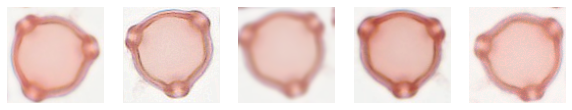

In [13]:
random.seed(seed)

plt.figure(figsize=(10,10))
sample_img = np.asarray(cv2.cvtColor(cv2.imread(SAMPLE_AUGMENTATION_PATH), cv2.COLOR_BGR2RGB))


augmented_images = augment_data(sample_img, 
                                lower_saturation= 0.6, 
                                upper_saturation = 1.3, 
                                max_sharpness= 10, 
                                sigma = 100.0)


for index, i in enumerate(augmented_images):
    
    ax = plt.subplot(1, 5, index + 1)
    plt.imshow(random_flip(i))
    plt.axis("off")
    

In [6]:
random.seed(seed)

total_number_of_images = 0

for path, subdirs, files in os.walk(folders["DB_CNN"]):
    for file in files:
        if os.path.splitext(file)[1] not in [".jpg", ".png"]:
            continue

        
        IMG_PATH = os.path.join(path, file)

        # Since images read by the python-opencv package usually are formatted by BGR colorspace, we need to change the colorchannels before casting it into a numpy array.
        sample_img = np.asarray((cv2.imread(IMG_PATH)))

        try:

            augmented_images = augment_data(sample_img, 
                                lower_saturation= 0.45, 
                                upper_saturation = 1.3, 
                                max_sharpness= 10, 
                                sigma = 100.0)
        except ValueError:
            print(file)
        
        for idx, img in enumerate(augmented_images):
            cv2.imwrite(os.path.join(path, "{}.png".format(uuid.uuid4())), img)

            total_number_of_images += 1

print("In total {} images were created by data augmnetation".format(total_number_of_images))

In total 0 images were created by data augmnetation


## 3.4 Dataset split - Training & Validation

In [51]:
random.seed(seed)

create_train_val_split(folders["DB_CNN"], folders["CNN_TRAINING_SPLITS"], fold)

5it [00:00,  5.52it/s]
5it [00:01,  4.94it/s]
5it [00:00,  5.68it/s]
5it [00:00,  5.41it/s]
5it [00:01,  4.83it/s]
5it [00:00,  5.21it/s]
5it [00:00,  5.80it/s]
5it [00:00,  5.66it/s]
5it [00:01,  4.77it/s]
5it [00:01,  4.08it/s]
5it [00:00,  5.58it/s]
5it [00:00,  6.11it/s]
5it [00:00,  5.77it/s]
5it [00:00,  5.42it/s]
5it [00:01,  4.54it/s]
5it [00:01,  4.42it/s]
5it [00:01,  4.29it/s]
5it [00:01,  4.38it/s]


## Classification - Model

The model consists uses a Transfer Learning approach, which is favourable for the small data size in this experiment. We employ a predifined CNN Architecture as feature extractor with weights that are trained on the imagenet dataset. We then add a Top Layer consisting of two Hidden Layers and one Output Layer. 

In [3]:
categories = ["APIACEAE", "ARTEMISIA", "ARTEMISIA_SIDE", "BETULA", "BETULA_SIDE","CHENOPODIACEAE", 
              "CYPERACEAE", "HELIANTHEMUM","LYCOPODIUM", "LYCOPODIUM_HALF", "NPP_CLASS1", "NPP_CLASS2", 
              "NPP_CLASS3", "NPP_CLASS4", "PINUS_WING", "POACEAE", "POACEAE_SIDE", "SALIX"]

In [7]:
img_width, img_height = cnnInputSize

def create_model():

    feature_extractor = keras.applications.xception.Xception(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        include_top=False,
        input_shape = (img_width,img_height,3),
    ) 


    feature_extractor.trainable = False

    input = feature_extractor.output
    x = keras.layers.GlobalAveragePooling2D()(input)
    x = keras.layers.Dense(200)(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(len(categories))(x)
    output = keras.layers.Softmax()(x)


    model = keras.models.Model(inputs = feature_extractor.input, outputs = output)


    #model.summary()

    return model

In [5]:
model = create_model()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 140, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 69, 69, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 69, 69, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 69, 69, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

### Training - Top Layer only!
This time we only train the top layer of the model and set the feature extractor as untrainable. 

In [ ]:

if not os.path.exists(folders["CNN_MODEL"]):
    os.makedirs(folders["CNN_LOGS"])
    os.makedirs(folders["CNN_WEIGHTS"])

model = create_model()
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1) # normalizes all pixel values between [-1,1]

# Save initial model weights:
INIT_WEIGHTS = os.path.join(folders["CNN_WEIGHTS"], "init_weights.h5")
model.save_weights(INIT_WEIGHTS, overwrite= True)


for split in os.listdir(folders["CNN_TRAINING_SPLITS"]):

    # Load initial model weights to restore the process after training of each split
    model.load_weights(INIT_WEIGHTS)

    # Load the training split of fold x
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], split, "train"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    # preprocess the images using normalization -> all pixel values between [-1,1]
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

    validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], split, "validation"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate= learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["acc"],
    )

    MODEL_PATH = os.path.join(folders["CNN_WEIGHTS"], split + ".h5")
    LOG_PATH = os.path.join(folders["CNN_LOGS"], split)

    callbecks = [tf.keras.callbacks.TensorBoard(log_dir = LOG_PATH), 
                EarlyStopping(monitor ='val_loss', patience = 10, min_delta= 0.1),
                ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', mode='min')]
    
    # Train model for the current split
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=validation_ds,
                        callbacks= callbecks,
                        use_multiprocessing= True,
                        workers= 8,
                        )

# Fine - Tuning the top 100 Layers

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '' # In case fine-tuning on GPU is too computationally expensive for your device, execute this line to execute traiing on CPU

In [ ]:
epochs = 20
batch_size = 16
learning_rate = 0.0002
random.seed(seed)



for split in range(fold):

    #model = create_model()
    model.load_weights(os.path.join(folders["CNN_WEIGHTS"], "split_{}.h5".format(split)))

    for layer in model.layers[-100:]:
        ### Batch Nornmalization Layers should not be set to True.
        if layer.name.split("_")[-1] != "bn":
            layer.trainable = True


    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], "split_{}".format(split), "train"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

    validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(folders["CNN_TRAINING_SPLITS"], "split_{}".format(split), "validation"),
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation = "gaussian")

    validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

    MODEL_PATH = os.path.join(CNN_FT_WEIGHT_PATH, "fine_tuned_{}".format(split) + ".h5")

    model.compile(
        optimizer=keras.optimizers.adam_v2.Adam(learning_rate= learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["acc"],
    )

    callbecks = [tf.keras.callbacks.TensorBoard(log_dir = folders["CNN_LOGS"]), 
                ModelCheckpoint(folders["CNN_MODEL"], save_best_only=True, monitor='val_loss', mode='min')]

    # Train model for the current split
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=validation_ds,
                        callbacks= callbecks,
                        use_multiprocessing= True,
                        workers= 4,
                        verbose = 1)

### Validation - Wrong Classifications in test set.

In [14]:
model = create_model()
model.load_weights(os.path.join(CNN_FT_WEIGHT_PATH, "fine_tuned_0.h5"))
model.trainable = False
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1)

In [9]:
### Setup Model:
#if model != None:
    #del model
model = create_model()
model.load_weights(os.path.join(CNN_FT_WEIGHT_PATH, "fine_tuned_0.h5"))
model.trainable = False
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1)

#### Load Test-Data
test_ds = tf.keras.utils.image_dataset_from_directory(
    EXPERIMENT_1,
    image_size=(img_height, img_width),
    batch_size = 1,
    interpolation = "gaussian"
)

labels = []
images = []
ori_images = []

evaluation = {}

for x,y in test_ds:
    labels.append(y)
    ori_images.append(x)
    images.append(normalization_layer(x)) 

labels = np.array(labels)

Found 198 files belonging to 18 classes.


In [16]:
model.load_weights(os.path.join(CNN_FT_WEIGHT_PATH, "fine_tuned_0.h5"))

In [19]:

CNN_WRONG_CLASSIFIED = os.path.join("model", "logs", "wrong_classified")

class_predictions = [model.predict(x) for x in images]


for index, prediction in enumerate(class_predictions):
    prediction = prediction[0]
    label = labels[index][0]

    prediction_label = categories[np.argmax(prediction)].split("_")[0]
    true_label = categories[label].split("_")[0]

    if true_label not in evaluation.keys():
        evaluation[true_label] = {"TP" : 0, "FP" : 0, "FN": 0}

    if prediction_label not in evaluation.keys():
        evaluation[prediction_label] = {"TP" : 0, "FP" : 0, "FN": 0}


    if true_label != prediction_label:
        print("Wrong classified: \n \t predicted value: {} with {:.2f} % \n \t true value: {} with {:.2f} %".format(prediction_label, np.max(prediction)*100, true_label, prediction[label] * 100))

        cv2.imwrite(os.path.join(CNN_WRONG_CLASSIFIED, "{}_{}_{}_{}.png".format(index, true_label, prediction_label, int(np.max(prediction)*100))), cv2.cvtColor(np.array(ori_images[index][0]), cv2.COLOR_RGB2BGR))
        evaluation[true_label]["FN"] = evaluation[true_label]["FN"] + 1
        evaluation[prediction_label]["FP"] = evaluation[prediction_label]["FP"] + 1

    else:
        evaluation[true_label]["TP"] = evaluation[true_label]["TP"] + 1

MSR = []
MSP = []
MSF1 = []
MSA = []
keys = list(evaluation.keys())
keys.sort()
for pollen in keys:
    if pollen != "NPP":
        TP = evaluation[pollen]["TP"]
        FP = evaluation[pollen]["FP"]
        FN = evaluation[pollen]["FN"]
        TN = len(images) - FP
        Recall = TP/(TP+FP)
        Precision = TP/(TP+FN)
        F1 = ((Recall * Precision) / (Recall + Precision))*2
        Accuracy = (TP+TN)/(TP+TN+FP+FN)
        MSR.append(Recall)
        MSP.append(Precision)
        MSF1.append(F1)
        MSA.append(Accuracy)
        print(pollen, "\n\tRecall:\t\t", str(Recall), "\n\tPrecision:\t", str(Precision), "\n\tF1-Score:\t", str(F1), "\n\tAccuracy\t", str(F1))

print("Mean Recall\t:", np.mean(MSR), "\tMean Precision:\t" , np.mean(MSP), "\tMean F1-Score\t", np.mean(MSF1), "\tMean Accuracy\t", np.mean(MSA))



Wrong classified: 
 	 predicted value: PINUS with 96.16 % 
 	 true value: SALIX with 2.83 %
APIACEAE 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
ARTEMISIA 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
BETULA 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
CHENOPODIACEAE 
	Recall:		 1.0 
	Precision:	 0.98 
	F1-Score:	 0.98989898989899 
	Accuracy	 0.98989898989899
CYPERACEAE 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
HELIANTHEMUM 
	Recall:		 1.0 
	Precision:	 0.9777777777777777 
	F1-Score:	 0.9887640449438202 
	Accuracy	 0.9887640449438202
LYCOPODIUM 
	Recall:		 1.0 
	Precision:	 1.0 
	F1-Score:	 1.0 
	Accuracy	 1.0
PINUS 
	Recall:		 0.9803921568627451 
	Precision:	 1.0 
	F1-Score:	 0.99009900990099 
	Accuracy	 0.99009900990099
POACEAE 
	Recall:		 0.9803921568627451 
	Precision:	 1.0 
	F1-Score:	 0.99009900990099 
	Accuracy	 0.99009900990099
SALIX 
	Recall:		 0.98 
	Precision:	 0.98 
	F1-Score:	 0.98 


### Visualization of Model Function
We use the Grad Cam and Occlusion Sensitivity procedure to visualize, how the feature extractor is performing on pollen images and to possibly detect pollen that pose certain issues on the classification. Fran°ois Chollet 

In [12]:
import matplotlib.cm as cm
from IPython.display import Image, display
normalization_layer = keras.layers.Rescaling(scale = 1./127.5, offset = -1)

Predicted: ('APIACEAE', 0.99999917)


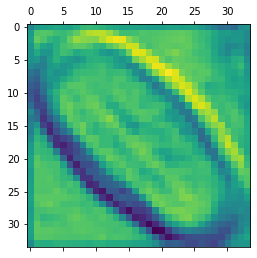

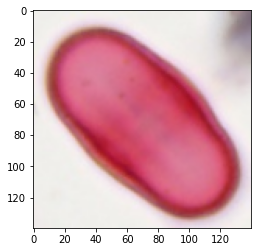

In [45]:
# Prepare image
img = np.asarray(cv2.resize(cv2.cvtColor(cv2.imread(SAMPLE_VISUALIZATION_PATH), cv2.COLOR_BGR2RGB ), dsize=(140,140)))
img_array = normalization_layer([img])

last_conv_layer_name = "block3_sepconv1"

def decode_predictions(preds, top = 5):
    decoded = []
    for i in range(0,top):
        index = np.argmax(preds)
        decoded.append((categories[index], np.max(preds)))
        preds[index] = 0.0

    return decoded

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds[0], top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)



# Display heatmap
plt.matshow(heatmap)
plt.show()
plt.imshow(img)
plt.show()

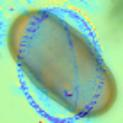

In [56]:
save_and_display_gradcam(SAMPLE_VISUALIZATION_PATH, heatmap)

True Label: images\EXPERIMENTS\EXPERIMENT_1\APIACEAE
Predicted: ('APIACEAE', 1.0)


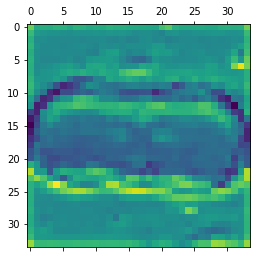

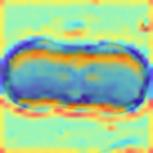

True Label: images\EXPERIMENTS\EXPERIMENT_1\ARTEMISIA
Predicted: ('ARTEMISIA_SIDE', 0.9999994)


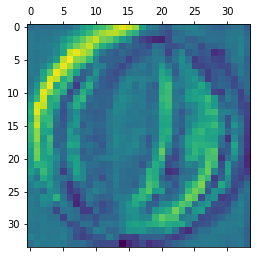

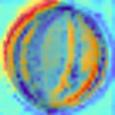

True Label: images\EXPERIMENTS\EXPERIMENT_1\BETULA
Predicted: ('BETULA', 1.0)


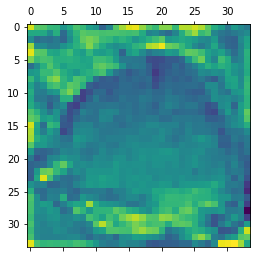

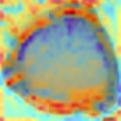

True Label: images\EXPERIMENTS\EXPERIMENT_1\CHENOPODIACEAE
Predicted: ('CHENOPODIACEAE', 1.0)


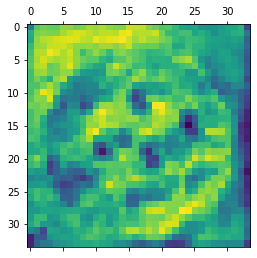

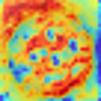

True Label: images\EXPERIMENTS\EXPERIMENT_1\CYPERACEAE
Predicted: ('CYPERACEAE', 1.0)


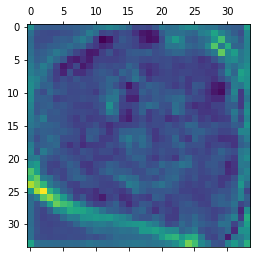

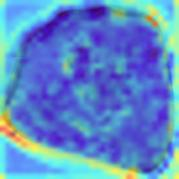

True Label: images\EXPERIMENTS\EXPERIMENT_1\HELIANTHEMUM
Predicted: ('HELIANTHEMUM', 1.0)


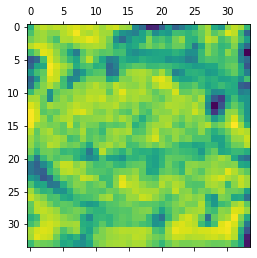

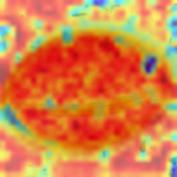

True Label: images\EXPERIMENTS\EXPERIMENT_1\LYCOPODIUM
Predicted: ('LYCOPODIUM', 1.0)


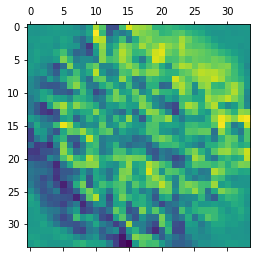

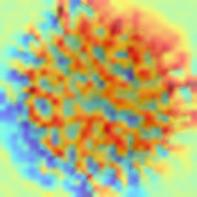

True Label: images\EXPERIMENTS\EXPERIMENT_1\PINUS_WING
Predicted: ('PINUS_WING', 1.0)


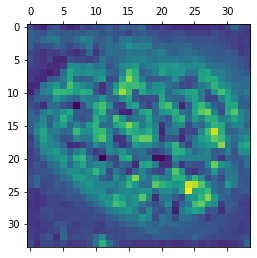

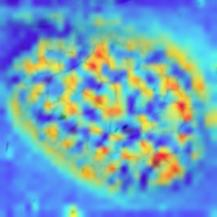

True Label: images\EXPERIMENTS\EXPERIMENT_1\POACEAE
Predicted: ('POACEAE_SIDE', 0.9998247)


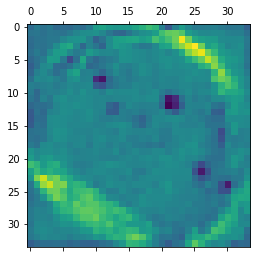

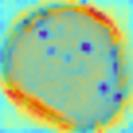

True Label: images\EXPERIMENTS\EXPERIMENT_1\SALIX
Predicted: ('SALIX', 1.0)


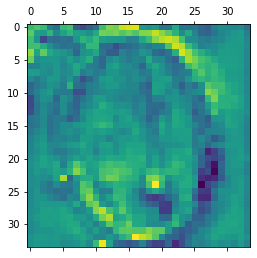

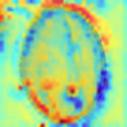

In [60]:
random.seed(seed)

for index, subdir in enumerate(os.listdir(EXPERIMENT_1)):
    SUB_PATH = os.path.join(EXPERIMENT_1, subdir)
    if len (os.listdir(SUB_PATH)) == 0:
        continue
    IMG_PATH = os.path.join(SUB_PATH, random.choice(os.listdir(SUB_PATH)))

    # Prepare image
    img_array = normalization_layer(get_img_array(IMG_PATH, size= (140,140)))

    last_conv_layer_name = "block3_sepconv1_act"

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    print("True Label:", SUB_PATH)
    print("Predicted:", decode_predictions(preds[0], top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = index)
    # Display heatmap
    plt.matshow(heatmap)
    plt.show()
    SAVE_PATH = os.path.join(VISUALIZATION_PATH, last_conv_layer_name, "GCAM_{}_{}.jpg".format(last_conv_layer_name, subdir))
    if not os.path.exists(os.path.dirname(SAVE_PATH)):
        os.makedirs(os.path.dirname(SAVE_PATH))
    save_and_display_gradcam(IMG_PATH, heatmap, cam_path= SAVE_PATH)


In [24]:
import keras
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

model = create_model()
model.trainable = False
model.load_weights(os.path.join(CNN_FT_WEIGHT_PATH, "fine_tuned_0.h5"))
epochs = 1
batch_size = 32
learning_rate = 0
random.seed(seed)


VISUALIZATION_PATH = os.path.join("visuals", "CNN_TOP_LAYER_ONLY")
if not os.path.exists(VISUALIZATION_PATH):
    os.makedirs(VISUALIZATION_PATH)

model.trainable = False


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
os.path.join(CNN_SPLITS_PATH, "split_0", "train"),
image_size=(img_height, img_width),
batch_size=batch_size,
interpolation = "gaussian")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
os.path.join(CNN_SPLITS_PATH, "split_0", "validation"),
image_size=(img_height, img_width),
batch_size=batch_size,
interpolation = "gaussian")

validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))

images = []
labels =[]

for idx, subdir in enumerate(os.listdir(EXPERIMENT_1)):
    SUB_PATH = os.path.join(EXPERIMENT_1, subdir)

    try:
        img = cv2.imread(os.path.join(SUB_PATH, random.choice(os.listdir(SUB_PATH))))
    except:
        continue
    img = cv2.resize(img, dsize= (140,140))
    img = np.asarray(img)
    images.append(normalization_layer(img))
    labels.append(idx)

images = np.asarray(images)
labels = np.asarray(labels)

callbecks = [OcclusionSensitivityCallback(validation_data= (images,labels), class_index= 8, patch_size= 18, output_dir= VISUALIZATION_PATH)]

model.compile(
    optimizer=keras.optimizers.adam_v2.Adam(learning_rate= learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"],
)

# Train model for the current split
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=validation_ds,
                    callbacks= callbecks,
                    use_multiprocessing= False,

                    )

Found 3019 files belonging to 18 classes.
Found 755 files belonging to 18 classes.
95/95 [==============================] - 11s 98ms/step - loss: 1.7023e-06 - acc: 1.0000 - val_loss: 0.0092 - val_acc: 0.9947


## Data Augmentation for Semantic Segmentation.
As for Classification, we will expand and augment our dataset for training the segmentation model as well. For this we make use of the package Albumentations which helps with the transformation of bounding box coordinates for transformations that involve rotations, flipping, cropping or zooming.

### Expand Database for Chenopodiaceae and Helianthemum

(-0.5, 1199.5, 1199.5, -0.5)

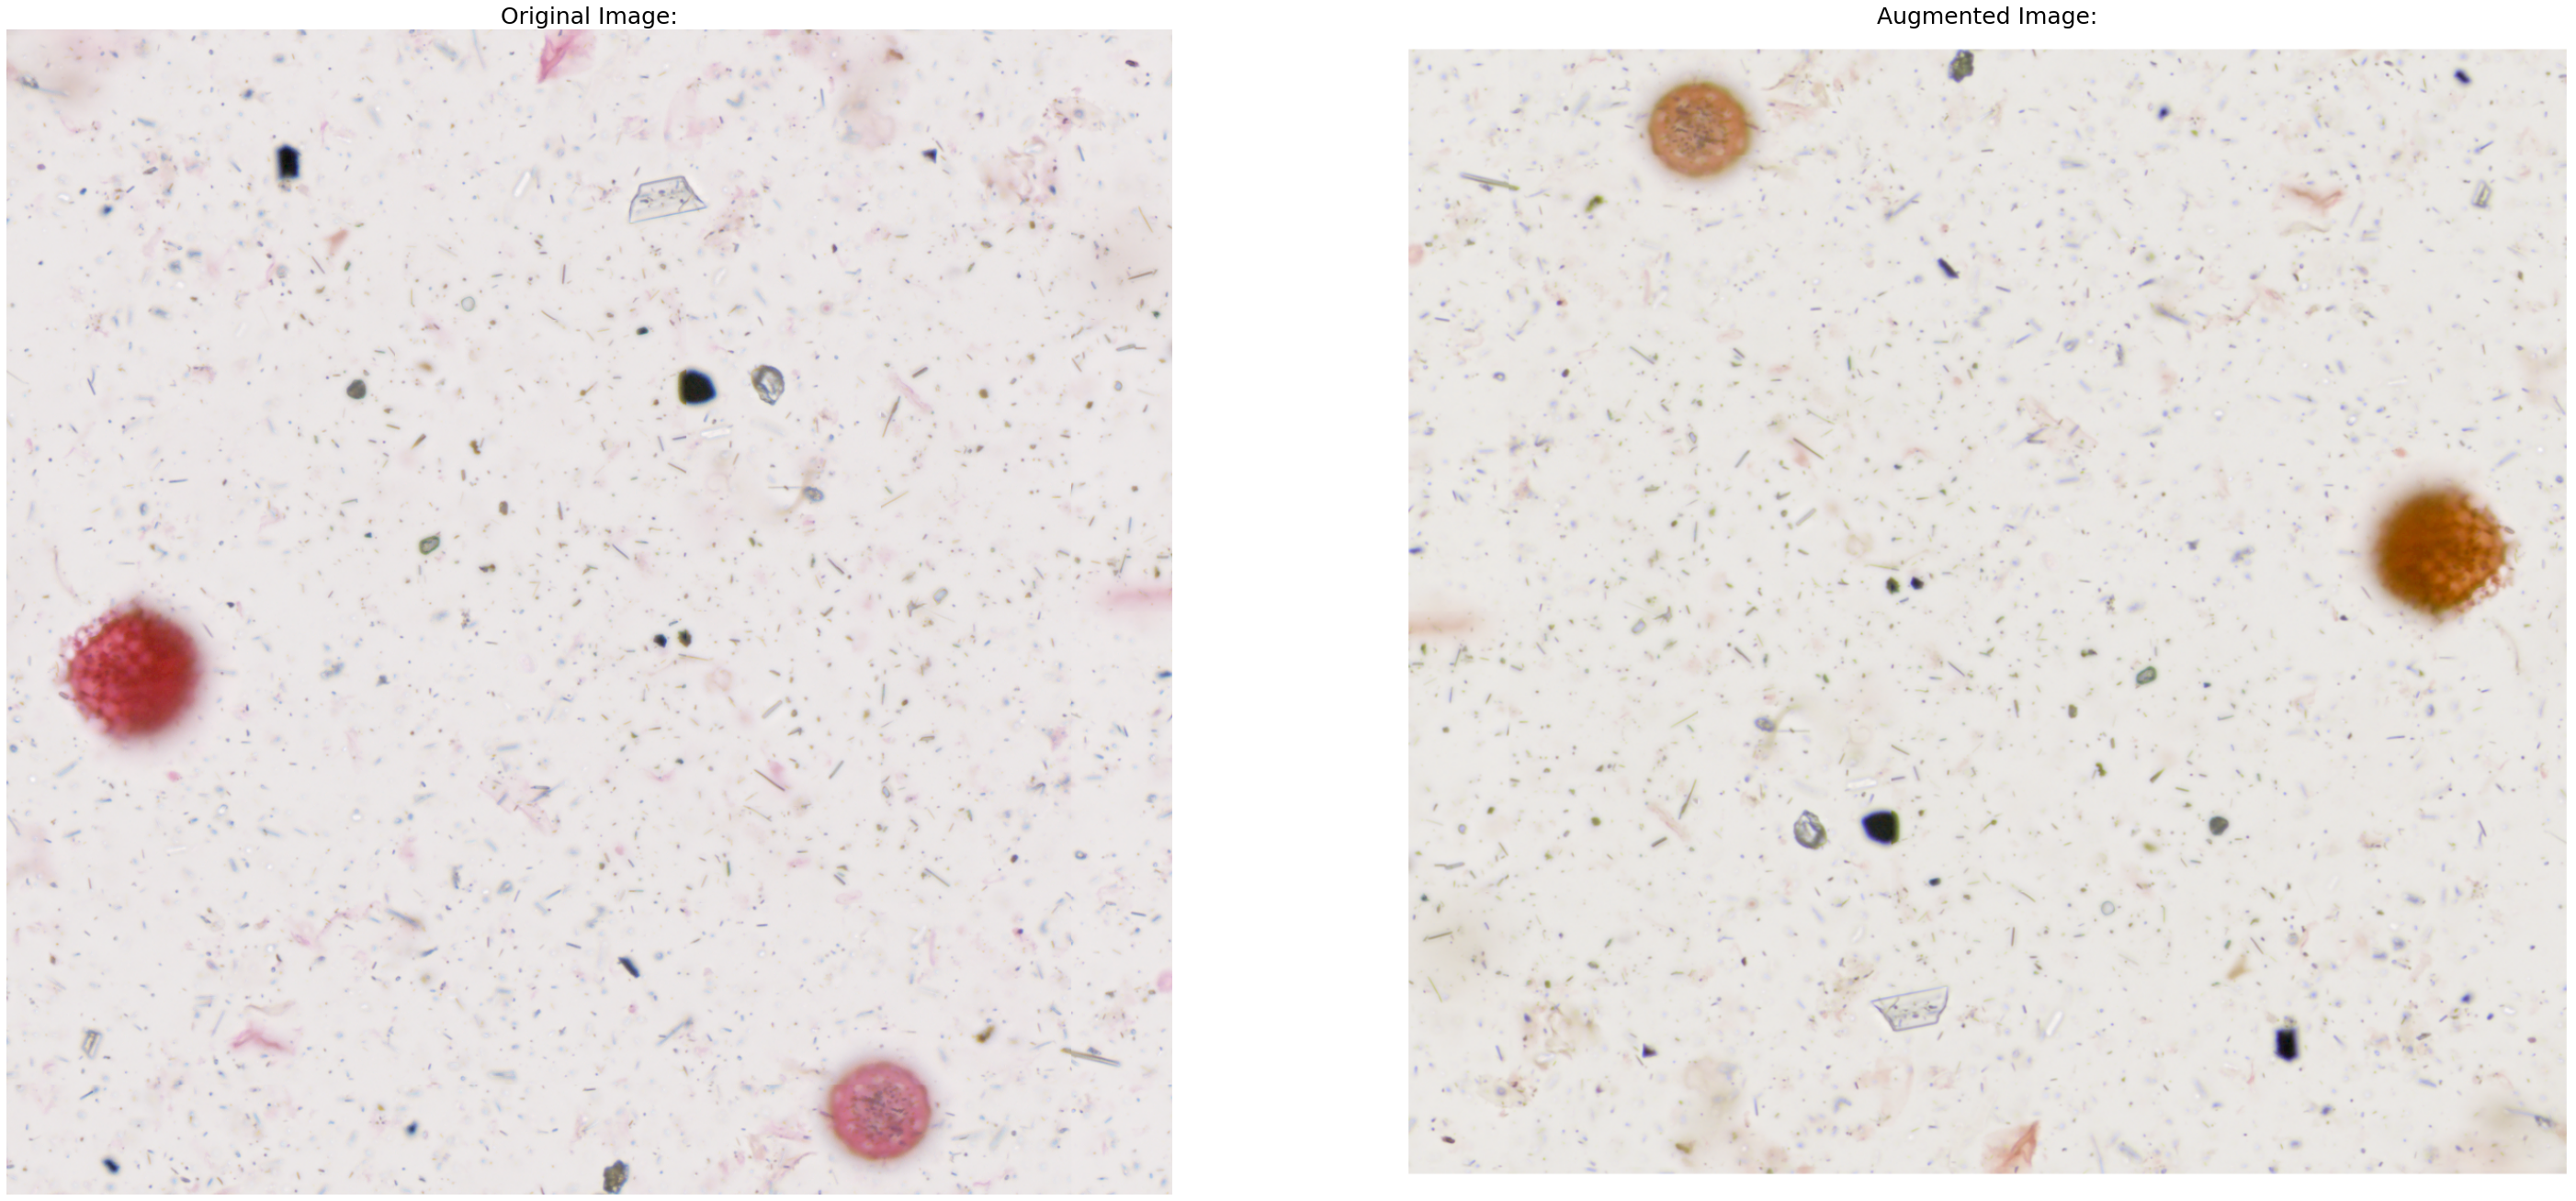

In [10]:

random.seed(seed)

plt.figure(figsize=(50,50))
sample_image = np.asarray(cv2.cvtColor(cv2.imread(SAMPLE_SEGMENTATION_PATH), cv2.COLOR_BGR2RGB))

ax = plt.subplot(1, 2, 1)
ax.title.set_text("Original Image:")
ax.title.set_size(25)
plt.imshow(random_flip(sample_image))
plt.axis("off")


ax = plt.subplot(1, 2, 2)
ax.title.set_text("Augmented Image:")
ax.title.set_size(25)
augmented_image = expand_data(sample_image, 0.5, height_factor= (0, 0.3), width_factor= (0, 0.3))
plt.imshow(random_flip(augmented_image))
plt.axis("off")


In [10]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET

images_dir = os.path.join("images", "splits", "SEGMENTATION_TEST")
save_dir = os.path.join("images", "DRAWN_SEGMENTATION")

for SUBCLASS in os.listdir(images_dir):
    SUB_PATH = os.path.join(images_dir, SUBCLASS)
    SAVE_PATH = os.path.join(save_dir, SUBCLASS)

    if not os.path.exists(SAVE_PATH):
        os.makedirs(os.path.join(SAVE_PATH))
    for file in os.listdir(SUB_PATH):
        if os.path.splitext(file)[1] in [".jpg", ".png"]:
            image = cv2.imread(os.path.join(SUB_PATH, file))
            annotation = os.path.join(SUB_PATH, os.path.splitext(file)[0] + ".xml")
            if not os.path.exists(annotation):
                continue
            tree = ET.parse(annotation)
            root = tree.getroot()

            annotations = []
            names = []
            quality = []
            

            for object in root.iter('object'):
                names.append(str(object.find("name").text))
                quality.append(int(object.find("difficult").text))

                for box in object.iter("bndbox"):

                    xmin = int(box.find('xmin').text)
                    ymin = int(box.find('ymin').text)
                    xmax = int(box.find('xmax').text)
                    ymax = int(box.find('ymax').text)
                
            
                annotations.append([xmin, ymin, xmax, ymax])

            for idx, bbox in enumerate(annotations):

                start_point = (int(bbox[0]), int(bbox[1]))
                end_point = (int(bbox[2]), int(bbox[3]))

                cv2.rectangle(image, start_point, end_point, color=(0,0,0), thickness=1)

                text = ""
                if quality[idx] == 1: text = "dif:" + names[idx]
                elif quality[idx] == 0: text = names[idx]

                
                cv2.putText(
                    image,
                    text,
                    (int(bbox[0]), int(bbox[1]) - 10),
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 0.6,
                    color = (0, 255, 0),
                    thickness=2
                )
                
            cv2.imwrite(os.path.join(SAVE_PATH, file), image)
            


In [137]:
# Expanding number of Helianthemum images from 35 up to 210
random.seed(seed)

CHE_POLLEN_PATH = os.path.join(REVIEWED_SEGMENTATION_PATH, "CHENOPODIACEAE")
CHE_ORIGINALS = os.listdir(CHE_POLLEN_PATH)

random.shuffle(CHE_ORIGINALS)

number = 0
while len(os.listdir(CHE_POLLEN_PATH)) < min_pollen_counts:
    if len(CHE_ORIGINALS) == 0:
        CHE_ORIGINALS = os.listdir(CHE_POLLEN_PATH)
    sample_file = os.path.join(CHE_POLLEN_PATH, CHE_ORIGINALS.pop())
    sample_img = np.array(cv2.imread(sample_file))
    augmented_img = expand_data(sample_img, 0.5, height_factor= (0, 0.1), width_factor= (0, 0.1))
    cv2.imwrite(os.path.join(CHE_POLLEN_PATH, "AUG{}_".format(number) + os.path.basename(sample_file)), augmented_img)
    number += 1


# Expanding number of Helianthemum images from ... up to ...
HE_POLLEN_PATH = os.path.join(REVIEWED_SEGMENTATION_PATH, "HELIANTHEMUM")
HE_ORIGINALS = os.listdir(HE_POLLEN_PATH)

random.shuffle(HE_ORIGINALS)

number = 0
while len(os.listdir(HE_POLLEN_PATH)) < min_pollen_counts:
    if len(HE_ORIGINALS) == 0:
        HE_ORIGINALS = os.listdir(HE_POLLEN_PATH)
    sample_file = os.path.join(HE_POLLEN_PATH, HE_ORIGINALS.pop())
    sample_img = np.array(cv2.imread(sample_file))
    augmented_img = expand_data(sample_img, 0.5, height_factor= (-0.1, 0.1), width_factor= (-0.1, 0.1))
    cv2.imwrite(os.path.join(HE_POLLEN_PATH, "AUG{}_".format(number) + os.path.basename(sample_file)), augmented_img)

### Create Balanced Databse for all pollen

In [140]:
build_database(REVIEWED_SEGMENTATION_PATH, DB_SEGMENTATION_PATH)

100%|██████████| 14/14 [00:02<00:00,  5.13it/s]


### Data Augmentation for expanding the whole Database 5-fold

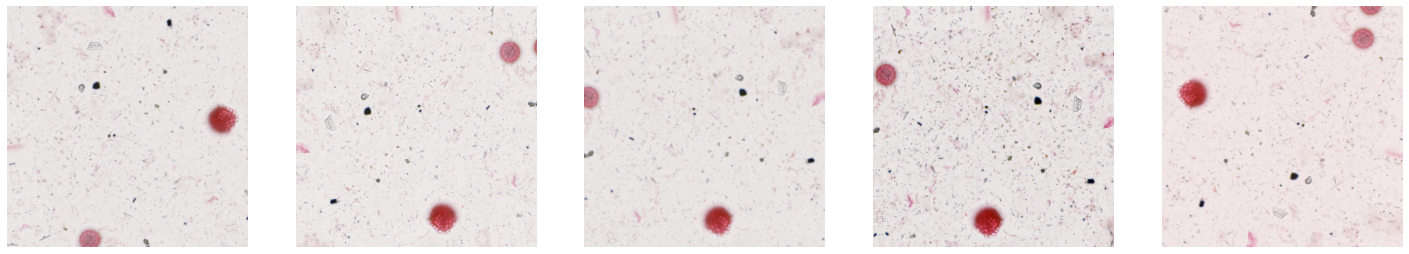

In [122]:
SAMPLE_SEGMENTATION_PATH = os.path.join("images", "sample_segmentation.jpg")
SAMPLE_SEGMENTATION_PATH_XML = os.path.join("images", "sample_segmentation.xml")
random.seed(seed)

plt.figure(figsize=(25,25))
sample_image = np.asarray(cv2.cvtColor(cv2.imread(SAMPLE_SEGMENTATION_PATH), cv2.COLOR_BGR2RGB))


augmented_images = augment_data(sample_image, 
                                lower_saturation= 0.6, 
                                upper_saturation = 1.3, 
                                max_sharpness= 10, 
                                sigma = 100.0)


for index, i in enumerate(augmented_images):
    ax = plt.subplot(1, 5, index + 1)
    plt.imshow(random_flip(i))
    plt.axis("off")
    


In [13]:
random.seed(seed)

total_number_of_images = 0

for path, subdirs, files in os.walk(SEGMENTATION_TEST_PATH):
    for file in files:
        IMG_PATH = os.path.join(path, file)

        # Since images read by the python-opencv package usually are formatted by BGR colorspace, we need to change the colorchannels before casting it into a numpy array.
        sample_img = np.asarray((cv2.imread(IMG_PATH)))

        augmented_images = augment_data(sample_img, 
                                lower_saturation= 0.45, 
                                upper_saturation = 1.3, 
                                max_sharpness= 10, 
                                sigma = 100.0)
        
        for idx, img in enumerate(augmented_images):
            cv2.imwrite(os.path.join(path, "AUG{}_".format(idx) + file), img)
            total_number_of_images += 1

print("In total {} images were created by data augmnetation".format(total_number_of_images))

In total 490 images were created by data augmnetation


### Validation - Train split

In [8]:
random.seed(seed)

if os.path.exists(SEGMENTATION_SPLITS_PATH):
    shutil.rmtree(SEGMENTATION_SPLITS_PATH)

os.makedirs(SEGMENTATION_SPLITS_PATH)

for subdir in os.listdir(DB_SEGMENTATION_PATH):
    SUB_PATH = os.path.join(DB_SEGMENTATION_PATH, subdir)

    files = [x for x in os.listdir(SUB_PATH) if os.path.splitext(x)[1] != ".xml"]
    random.shuffle(files)
    splits = make_split(files, fold)

    for index, split in tqdm.tqdm(enumerate(splits)):
        SPLIT_PATH = os.path.join(SEGMENTATION_SPLITS_PATH, "split_{}".format(index))
        VAL_SPLIT = os.path.join(SPLIT_PATH, "validation")
        TRAIN_SPLIT = os.path.join(SPLIT_PATH, "train")

        if not os.path.exists(SPLIT_PATH):
            os.makedirs(SPLIT_PATH)
            os.makedirs(VAL_SPLIT)
            os.makedirs(TRAIN_SPLIT)

        for file in split:
            shutil.copy(os.path.join(SUB_PATH, file), os.path.join(VAL_SPLIT, file))
            shutil.copy(os.path.join(SUB_PATH, os.path.splitext(file)[0] + ".xml"), os.path.join(VAL_SPLIT, os.path.splitext(file)[0] + ".xml"))

        for split in [x for i, x in enumerate(splits) if i != index]:
            for file in split:
                shutil.copy(os.path.join(SUB_PATH, file), os.path.join(TRAIN_SPLIT, file))
                shutil.copy(os.path.join(SUB_PATH, os.path.splitext(file)[0] + ".xml"), os.path.join(TRAIN_SPLIT, os.path.splitext(file)[0] + ".xml"))

5it [00:02,  1.82it/s]
5it [00:02,  1.80it/s]
5it [00:02,  1.80it/s]
5it [00:02,  1.75it/s]
5it [00:03,  1.65it/s]
5it [00:03,  1.63it/s]
5it [00:03,  1.44it/s]
5it [00:04,  1.22it/s]
5it [00:03,  1.39it/s]
5it [00:03,  1.46it/s]
5it [00:04,  1.07it/s]
5it [00:04,  1.16it/s]
5it [00:04,  1.22it/s]
5it [00:04,  1.15it/s]


### Training and Evaluation

For Resource purposes we employed our training on paperspace.com using and modifying the code writen in GitHub-Link

### Using Object Detection to detect pollen grains.

In [ ]:
import tarfile
my_tar = tarfile.open('model/SEGMENTATION_MODEL/CENTERHOURGLASS.tar.gz')
my_tar.extractall('./model/SEGMENTATION_MODEL/') # specify which folder to extract to
my_tar.close()

In [10]:
from object_detection.builders import model_builder
from object_detection.utils import config_util


PIPELINE_CONFIG = os.path.join("model", "SEGMENTATION_MODEL", "CENTERNETHG104_FINAL", "pipeline.config")
CHKPT_PATH = os.path.join("model",  "SEGMENTATION_MODEL", "CENTERNETHG104_FINAL", "ckpt-9")

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(CHKPT_PATH).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [13]:
INPUT_PATH = "D:/Test/e31/input/"
OUTPUT_PATH = "D:/Test/e31/output/"
CNN_PATH = os.path.join(folders["CNN_FINE_TUNE"], "fine_tuned_0.h5")
categories = ["APIACEAE", "ARTEMISIA", "ARTEMISIA_SIDE", "BETULA", "BETULA_SIDE","CHENOPODIACEAE", "CYPERACEAE", "HELIANTHEMUM",
              "LYCOPODIUM", "LYCOPODIUM_HALF", "PINUS_WING", "POACEAE", "POACEAE_SIDE", "SALIX","NPP_CLASS1", "NPP_CLASS2", "NPP_CLASS3", "NPP_CLASS4"]

count_classes = ["APIACEAE", "ARTEMISIA", "BETULA", "CHENOPODIACEAE", "CYPERACEAE", "HELIANTHEMUM", "PINUS", "POACEAE", "SALIX","OTHERS", "LYCOPODIUM", "OFP"]

model = create_model()
model.trainable = False
model.load_weights(CNN_PATH)
class_th = [0.4, 0.45, 0.45, 0.6, 0.6, 0.7, 0.55, 0.3, 0.6, 0.45, 0.75, 0.6, 0.6, 0.8, 0.9, 0.9, 0.9, 0.9]

try:
    with open(os.path.join("DB_1.csv"), "w", newline="") as outputfile:
        outputfile.write(";".join(str(e) for e in count_classes)+"\n")

        for idx, subdir in enumerate(os.listdir(INPUT_PATH)):

            SUB_INPUT_PATH = os.path.join(INPUT_PATH, subdir)
            SUB_OUTPUT_PATH = os.path.join(OUTPUT_PATH, "DETECTION_{}".format(subdir.split("__")[1]))
            DB = count_pollen(SUB_INPUT_PATH, SUB_OUTPUT_PATH, cnn_model = model, threshold= class_th, seg_threshold= 0.2,categories= categories, inspect_boxes= True)


            outputfile.write(";".join(str(DB[key]) for key in count_classes))
            outputfile.write("\n")

except KeyboardInterrupt:
    print("Process was interrupted!")
finally:
    print("Core Analysis terminated")


Initialized automated Pollen Analysis on CLASSIFY__0209


 10%|█         | 534/5334 [06:50<1:01:26,  1.30it/s]

Core Analysis terminated
